In [68]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [69]:
%matplotlib inline

In [70]:
ssc = SQLContext(sc)
tweets = ssc.read.parquet("/tmp/tweet-corpus")
tweets.cache()

DataFrame[_1: array<string>, _2: double]

In [71]:
tweets.count()

5003

In [72]:
df = tweets.toPandas()
df.columns = ["tokens", "label"]
df.head()

,tokens,label
0,"[, the case, be the, would be, feel, we had, w...",1
1,"[, satu, tapii, kan, cuma, jam sama, handshak,...",0
2,"[, want, tattoo, want tattoo, i, tattoo , i want]",0
3,"[, maybe, yeah maybe, rawr yeah, rawr, know, k...",0
4,"[, ay grabe, grabe, , usernam ay, usernam, ay]",0


## Preprocessing

### Using `HashingTF`, a simple bag of words model

In [73]:
from pyspark.mllib.feature import IDF
from pyspark.mllib.feature import HashingTF
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.classification import LabeledPoint

In [74]:
coeff = 3000
hashingTf = HashingTF(coeff)

In [75]:
#vectors = sc.parallelize([hashingTf.transform(tokens) for tokens in df._1])
#idf = IDF().fit(vectors)

In [76]:
def featurize(tokens): return hashingTf.transform(tokens)
#def tfidf(tokens): return idf.transform(tf(tokens))

In [77]:
df['lpoint'] = df.apply(lambda row: LabeledPoint(row['label'], featurize(row['tokens'])), axis=1)
df

,tokens,label,lpoint
0,"[, the case, be the, would be, feel, we had, w...",1,"(1.0,(3000,[0,79,91,189,241,344,446,656,762,96..."
1,"[, satu, tapii, kan, cuma, jam sama, handshak,...",0,"(0.0,(3000,[0,13,74,203,239,250,256,292,318,51..."
2,"[, want, tattoo, want tattoo, i, tattoo , i want]",0,"(0.0,(3000,[0,186,438,1424,1903,2185,2622],[1...."
3,"[, maybe, yeah maybe, rawr yeah, rawr, know, k...",0,"(0.0,(3000,[0,116,437,675,1142,1216,1249,1465,..."
4,"[, ay grabe, grabe, , usernam ay, usernam, ay]",0,"(0.0,(3000,[0,960,1216,1321,1709,1833,2954],[1..."
5,"[, aqui, calor aqui, sempr, tem, calor, aqui s...",0,"(0.0,(3000,[0,269,276,889,1216,1635,1774,2460,..."
6,"[, usernam usernam, want, him, i, same, i want...",0,"(0.0,(3000,[0,254,438,615,695,725,782,1125,121..."
7,"[, 1990 an, an waktu, masih, ngetwitnya, ngetw...",0,"(0.0,(3000,[0,11,69,138,252,291,480,584,865,95..."
8,"[, usernam cant, cant , usernam, cant]",0,"(0.0,(3000,[0,1216,1767,2514,2691],[1.0,1.0,1...."
9,[],0,"(0.0,(3000,[0],[1.0]))"


Create train/test split

In [78]:
# create boolean mask
msk = np.random.rand(len(df)) < 0.80
train = df[msk]
test = df[~msk]

### Distribution of labels of training set

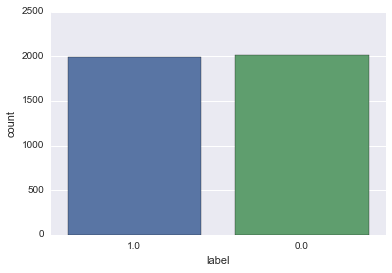

In [79]:
_ = sns.countplot(x="label", data=train)

### Distribution of labels of test set

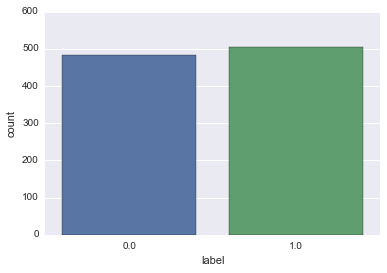

In [80]:
_ = sns.countplot(x="label", data=test)

### Run PCA

In [81]:
from pyspark.mllib.feature import PCA

In [82]:
df

,tokens,label,lpoint
0,"[, the case, be the, would be, feel, we had, w...",1,"(1.0,(3000,[0,79,91,189,241,344,446,656,762,96..."
1,"[, satu, tapii, kan, cuma, jam sama, handshak,...",0,"(0.0,(3000,[0,13,74,203,239,250,256,292,318,51..."
2,"[, want, tattoo, want tattoo, i, tattoo , i want]",0,"(0.0,(3000,[0,186,438,1424,1903,2185,2622],[1...."
3,"[, maybe, yeah maybe, rawr yeah, rawr, know, k...",0,"(0.0,(3000,[0,116,437,675,1142,1216,1249,1465,..."
4,"[, ay grabe, grabe, , usernam ay, usernam, ay]",0,"(0.0,(3000,[0,960,1216,1321,1709,1833,2954],[1..."
5,"[, aqui, calor aqui, sempr, tem, calor, aqui s...",0,"(0.0,(3000,[0,269,276,889,1216,1635,1774,2460,..."
6,"[, usernam usernam, want, him, i, same, i want...",0,"(0.0,(3000,[0,254,438,615,695,725,782,1125,121..."
7,"[, 1990 an, an waktu, masih, ngetwitnya, ngetw...",0,"(0.0,(3000,[0,11,69,138,252,291,480,584,865,95..."
8,"[, usernam cant, cant , usernam, cant]",0,"(0.0,(3000,[0,1216,1767,2514,2691],[1.0,1.0,1...."
9,[],0,"(0.0,(3000,[0],[1.0]))"


In [83]:
#lpoints = df['lpoint']
#rdd = sc.parallelize(lpoints.map(lambda point: point.features).tolist())
#pca = PCA(3).fit(rdd)
#df['pca'] = df.apply(lambda row: pca.transform(row['lpoint'].features), axis=1)
#df['pca_0'] = df.apply(lambda row: row['pca'][0], axis=1)
#df['pca_1'] = df.apply(lambda row: row['pca'][1], axis=1)
#viz = df[['label', 'pca_0', 'pca_1']]

In [84]:
#_ = sns.pairplot(viz, vars=['pca_0', 'pca_1'], hue="label", size=6.0)

# Train a Logistic Regression classifier

In [85]:
from pyspark.mllib.classification import LogisticRegressionWithSGD
from pyspark.mllib.classification import LabeledPoint

Let's add a new column with `LabeledPoint`s consisting of TF-IDF vectors.

In [86]:
train_rdd = sc.parallelize(train.lpoint)

Now train the logistic regression estimator.

In [87]:
lr = LogisticRegressionWithSGD.train(train_rdd, initialWeights=Vectors.zeros(coeff), iterations=200)

# Test

In [88]:
test['pred'] = test.apply(lambda row: lr.predict(row['lpoint'].features), axis=1)

/Users/rene/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [89]:
test

,tokens,label,lpoint,pred
8,"[, usernam cant, cant , usernam, cant]",0,"(0.0,(3000,[0,1216,1767,2514,2691],[1.0,1.0,1....",0
10,"[, gigih cari, cari kat, googl, pink , kat, su...",0,"(0.0,(3000,[0,23,96,376,587,849,1319,1350,1373...",0
27,"[, httpst, emphasi on, open, on, emphasi, coz...",0,"(0.0,(3000,[0,5,625,700,1092,1866,2289,2306,23...",0
41,"[want to, , for, art, cant stop, have heart, m...",0,"(0.0,(3000,[0,12,25,56,92,191,290,356,438,542,...",0
44,"[, feel, person i, feel comfort, talk to, coul...",0,"(0.0,(3000,[0,214,307,317,389,432,558,585,608,...",0
46,"[saya haru, , saya, lagi, bro, gimana lagi, la...",0,"(0.0,(3000,[0,230,583,672,693,781,1050,1244,17...",0
47,"[, usernam disgusting, sad , have, she must, j...",0,"(0.0,(3000,[0,138,542,681,688,792,916,1216,126...",0
59,"[incident, allah maaf, le, , ya, in, sad incid...",0,"(0.0,(3000,[0,17,22,210,259,278,441,447,502,90...",0
62,"[, dean, httpst, care, coxuqjh2lhvm, take, ca...",0,"(0.0,(3000,[0,289,1103,1131,1196,1549,1572,170...",0
64,"[, tengo que, me tengo, igual, ltima creo, use...",0,"(0.0,(3000,[0,332,655,732,812,839,857,884,949,...",1


# Metrics

In [90]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.evaluation import MulticlassMetrics

In [91]:
scoreAndLabels = test.apply(lambda row: (float(row['pred']), row['lpoint'].label), axis=1)
scoreAndLabels = sc.parallelize(scoreAndLabels)

In [92]:
binary_metrics = BinaryClassificationMetrics(scoreAndLabels)

In [93]:
binary_metrics.areaUnderPR

0.7816544946099755

In [94]:
binary_metrics.areaUnderROC

0.7012045925089404

In [95]:
mult_metrics = MulticlassMetrics(scoreAndLabels)

In [96]:
mult_metrics.precision()

0.7007077856420627

In [97]:
mult_metrics.recall()

0.7007077856420627

In [98]:
max(test.label.mean(), 1 - test.label.mean())

0.5116279069767442

# Cross validation

In [99]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF

lr = LogisticRegression()
tf = HashingTF(inputCol="tokens", outputCol="features")
pipeline = Pipeline(stages=[tf, lr])

In [100]:
pdf = ssc.createDataFrame(df)

In [101]:
dataset = sqlContext.createDataFrame(
[(point.features, point.label) for point in df['lpoint']],
["features", "label"])
ptrain = ssc.createDataFrame(train)
ptest = ssc.createDataFrame(test[['tokens','label','lpoint']])

In [102]:
model = pipeline.fit(ptrain)

In [103]:
prediction = model.transform(ptest)

In [104]:
result = prediction.select("tokens", "label", "prediction").toPandas()

In [106]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [1]:
grid = ParamGridBuilder().addGrid(lr.maxIter, [0, 1]).build()
evaluator = BinaryClassificationEvaluator()
cv = CrossValidator(estimator=lr, estimatorParamMaps=grid, evaluator=evaluator)

cvModel = cv.fit(dataset)
evaluator.evaluate(cvModel.transform(dataset))
type(cvModel)

NameError: name 'ParamGridBuilder' is not defined

In [117]:
weights = cvModel.bestModel.weights

### Use initial weights of best model

In [128]:
lr_new = LogisticRegressionWithSGD.train(train_rdd, initialWeights=weights, iterations=200)
test['pred_new'] = test.apply(lambda row: lr_new.predict(row['lpoint'].features), axis=1)

/Users/rene/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from IPython.kernel.zmq import kernelapp as app


In [129]:
scoreAndLabels = test.apply(lambda row: (float(row['pred_new']), row['lpoint'].label), axis=1)
scoreAndLabels = sc.parallelize(scoreAndLabels)

In [130]:
binary_metrics = BinaryClassificationMetrics(scoreAndLabels)

In [131]:
binary_metrics.areaUnderROC

0.8056182947487296

In [132]:
binary_metrics.areaUnderPR

0.8613475209275279

In [133]:
mult_metrics = MulticlassMetrics(scoreAndLabels)

In [134]:
mult_metrics.precision()

0.8048533872598584